In [1]:
!pip install -U jax[cuda112]==0.3.17 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jaxlib[cuda112]==0.3.17 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax
!pip install dm-haiku
!pip install tensorflow-probability==0.17
!pip install lark==1.1.2
!pip install git+https://github.com/blackjax-devs/blackjax.git
!apt update
!apt install -y graphviz
!apt-get -y install swig
!pip install smac
!pip install graphviz
!pip install gplearn

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.24-py3-none-any.whl size=1297412 sha256=0826405ff2ae02cef01cf14ab26ca2f785ae38c2c8ea1d09400134c948e19192
  Stored in directory: /root/.cache/pip/wheels/13/d4/90/1904bbdf0ee77093daa3bf6a4939e5ddc266402262423e29d1
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 MB 14.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.8+cuda11.cudnn82
    Uninstalling jaxlib-0.3.8+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.3.8+cuda11.cudnn82
  

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 1

In [3]:
if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn
import jax
import haiku as hk
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import blackjax
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from functools import partial
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from nn_util import *
from gibbs_sampler import *
plt.style.use('ggplot')
%load_ext autoreload

In [4]:
jax.default_backend()

'gpu'

In [5]:
if SERVER:
    data_dir = "."
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

### Load Data

In [6]:
p = 100
seeds, data_dfs, net_dfs, feat_ls = load_bmm_files(f"{data_dir}/bmm_data_thr_5_F_8_f{p}")

In [7]:
%autoreload
seed_idx = 6
seed, net, data = prepare_data(seeds, seed_idx, data_dfs, net_dfs, test_size=0.2, out_val_size=0.4)
print(f"seed: {seed}")
X_train, X_out_val, X_test, y_train, y_out_val, y_test = data
# X_train, X_out_val, y_train, y_out_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed, shuffle=True)
X_train, X_test, y_train, y_test = jax.device_put(X_train), jax.device_put(X_test), \
                                   jax.device_put(y_train), jax.device_put(y_test)

X_out_val, y_out_val = jax.device_put(X_out_val), jax.device_put(y_out_val)
# p = X_train.shape[1]
rng_key = jax.random.PRNGKey(seed)

seed: 220


### Baseline Logistic Regression

In [8]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [9]:
from sklearn.linear_model import LogisticRegression


log_param_grid = {"C":np.logspace(-2, 1, 10)}
log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=1, scoring="roc_auc", cv=cv).fit(X_train, y_train)
clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
cv_score = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=cv))
clf.fit(X_train, y_train)
test_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print(f"cv score: {cv_score}, test_score: {test_score}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
cv score: 0.7141653843826707, test_score: 0.6964807962228895


### BNN

In [18]:
%autoreload
from smac.facade.smac_mf_facade import SMAC4MF
from smac.scenario.scenario import Scenario
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sgmcmc import MixedSGMCMC
from run_nn_fisher_test_exp import run_logistic_regression
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import (
    CategoricalHyperparameter,
    UniformFloatHyperparameter,
    UniformIntegerHyperparameter,
)

from ConfigSpace import InCondition, Configuration



def get_configspace(input_size)-> ConfigurationSpace:
    # Build Configuration Space which defines all parameters and their ranges.

    if input_size == 100:
        layer_dims  = [50, 60, 70, 80]
    else:
        layer_dims = [250, 300, 350, 400]

    cs  = ConfigurationSpace()

    layer_dim = CategoricalHyperparameter("layer_dim", layer_dims, default_value=layer_dims[0])
    activation = CategoricalHyperparameter("activation", ["relu", "tanh"], default_value="tanh")
    # lr_schedule = CategoricalHyperparameter("lr_schedule", ["cyclical"], default_value="cyclical")
    disc_lr = CategoricalHyperparameter("disc_lr", [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5] , default_value=1e-1)
    contin_lr = CategoricalHyperparameter("contin_lr", [1e-5, 1e-4, 1e-3, 1e-2], default_value=1e-5) #TODO Extend range
    # num_cycles = CategoricalHyperparameter("num_cycles", [3, 4, 5], default_value=5)
    # beta = CategoricalHyperparameter("beta", [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], default_value=0.9)
    batch_sze = CategoricalHyperparameter("batch_size", [32, 64, 128, 256], default_value=32)
    thinning_interval = CategoricalHyperparameter("thinning_interval", [50, 100, 150, 200], default_value=100)
    # eta = UniformFloatHyperparameter("eta", lower=0.1, upper=100., log=True)
    eta = CategoricalHyperparameter("eta", [0.1, 1., 5, 10., 50., 100.], default_value=1.)
    # mu = UniformFloatHyperparameter("mu", lower=0.1, upper=100, log=True)
    mu = CategoricalHyperparameter("mu", [0.1, 1., 5, 10., 50., 100.], default_value=1.)
    temp = CategoricalHyperparameter("temp", [1e-3, 1e-2, 1e-1, 0.5,  1.], default_value=1e-1)
    sigma = CategoricalHyperparameter("sigma", [1e-3, 1e-2, 1e-1, 0.5, 1., 10.], default_value=1.)
    # Add hyper-parameters
    cs.add_hyperparameters([layer_dim, activation, disc_lr, contin_lr, eta, mu, temp, sigma, batch_sze, thinning_interval])

    # # Cyclical SG-MCMC condition
    # use_cycle_len = InCondition(child=cycle_len, parent=lr_schedule, values=["cyclical"])
    # use_beta = InCondition(child=beta, parent=lr_schedule, values=["cyclical"])
    #
    # cs.add_conditions([use_cycle_len, use_beta])

    return cs

def generate_train_cs(seed, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    # X_tr, X_val, y_tr, y_val = train_test_split(X, y, stratify=y, test_size=0.1, shuffle=seed)
    def train_cs(config: Configuration, budget: int)-> float:

        params = {"disc_lr": config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": config["batch_size"],
                  "mu": config["mu"], "eta": config["eta"], "temp": config["temp"],
                  "sigma": config["sigma"], "thinning_interval": config["thinning_interval"]}

        # print(params)

        mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=budget, n_warmup=1000, lr_schedule="exponential",
                            n_chains=5, layer_dims=[config["layer_dim"]], **params)

        cv_score_1 = np.mean(cross_val_score(mixed_sgmcmc, X, y,  cv=cv, fit_params={
            "activation_fns": [config["activation"]], "J": net
        }))


        # mixed_sgmcmc.fit(X_tr, y_tr, activation_fns=[config["activation"]], J=net)
        # gamma_means = jnp.mean(jnp.mean(mixed_sgmcmc.states_.discrete_position, axis=0), axis=0)
        # gamma_means_idx_s = np.argsort(gamma_means)[::-1]
        #
        # bnn_sel_fts = gamma_means_idx_s[:ft_len]
        # #
        # X_tr_sel, X_val_sel = X_tr[:,bnn_sel_fts], X_val[:,bnn_sel_fts]
        #
        # _, _, val_score = run_logistic_regression(X_tr_sel, X_val_sel, y_tr, y_val, cv, verbose=0)

        return 1 - (cv_score_1)


    return train_cs


def optimize_hyper_parameters(seed, X, y, total_time=60):
    cs = get_configspace(X.shape[1])
    scenario = Scenario({
        "run_obj": "quality",
        "wallclock-limit": total_time,
        "cs": cs,
        "deterministic": True,
        "cutoff": 10,  # runtime limit for the target algorithm
        "verbose_level": "DEBUG", 
        "seed": seed
    })

    max_steps = 5000

    train_cs = generate_train_cs(seed, X, y)

    intensifier_kwargs = {"initial_budget": 1500, "max_budget": max_steps}

    smac = SMAC4MF(scenario=scenario, rng=np.random.RandomState(seed),
                   tae_runner=train_cs, intensifier_kwargs=intensifier_kwargs)

    tae = smac.get_tae_runner()

    try:
        incumbent = smac.optimize()

    finally:
        incumbent = smac.solver.incumbent


    inc_val = tae.run(config=incumbent, budget=max_steps, seed=seed)

    return incumbent, 1 - inc_val[1], smac


In [232]:
X_train, X_test, y_train, y_test = jax.device_put(X_train), jax.device_put(X_test), \
                                   jax.device_put(y_train), jax.device_put(y_test)
p = X_train.shape[1]
rng_key = jax.random.PRNGKey(seed)
config, cv_score, smac = optimize_hyper_parameters(seed, X_train, y_train, total_time=180)
cv_score

/usr/local/lib/python3.9/dist-packages/smac/intensification/parallel_scheduling.py:154: UserWarning: Hyperband is executed with 1 workers only. Consider to use pynisher to use all available workers.
  warnings.warn(


0.7264258551052072

In [119]:
smac.get_trajectory()[-1].budget

1000.0

In [271]:
config

Configuration(values={
  'activation': 'relu',
  'batch_size': 64,
  'contin_lr': 0.001,
  'disc_lr': 1e-05,
  'eta': 10.0,
  'layer_dim': 50,
  'mu': 5,
  'sigma': 10.0,
  'temp': 1.0,
  'thinning_interval': 100,
})

In [274]:
%autoreload
from sgmcmc import MixedSGMCMC
params = {"disc_lr": config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": config["batch_size"],
          "mu": config["mu"], "eta": config["eta"], "temp": config["temp"],
          "sigma":config["sigma"], "thinning_interval": config["thinning_interval"]}

mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=2000, n_warmup=500, n_chains=5, lr_schedule="exponential",
                     layer_dims=[config["layer_dim"]], **params)

# cv_score_bnn = np.mean(cross_val_score(mixed_sgmcmc, X_train, y_train,  cv=cv, fit_params={
#             "activation_fns": [config["activation"]], "J": net
#         }))
# print(cv_score_bnn)
mixed_sgmcmc.fit(X_train, y_train, activation_fns=[config["activation"]], J=net)
print(f"Num models: {mixed_sgmcmc.states_.discrete_position.shape[0]}")
test_score_bnn = mixed_sgmcmc.score(X_test, y_test)

print(test_score_bnn)

Num models: 75
0.6897060418578944


In [128]:
disc_states = mixed_sgmcmc.states_.discrete_position.reshape(mixed_sgmcmc.n_chains, -1,
                                         mixed_sgmcmc.states_.discrete_position.shape[-1])
contin_states = jax.tree_util.tree_map(lambda x: jnp.moveaxis(x.reshape(mixed_sgmcmc.n_chains, -1, x.shape[-1]), 0, 1), mixed_sgmcmc.states_.contin_position)

In [31]:
contin_states = tree_utils.tree_unstack(mixed_sgmcmc.states_.contin_position)
disc_states = mixed_sgmcmc.states_.discrete_position

disc_logprior_fn = generate_disc_logprior_fn(net, mixed_sgmcmc.eta, mixed_sgmcmc.mu)
contin_logprior_fn = generate_contin_logprior_fn(mixed_sgmcmc.sigma)

contin_log_probs = []
disc_log_probs = []
log_lls = []

for c in range(mixed_sgmcmc.n_chains):
    chain_disc_log_probs = []
    chain_contin_log_probs = []
    for i in range(len(mixed_sgmcmc.disc_states[c])):
        # idxs = jax.random.choice(keys[i], jnp.arange(data_size), (32,), replace=False)
        # batches = make_batch(idxs, train_data.x, train_data.y)
        chain_disc_log_probs.append(disc_logprior_fn(mixed_sgmcmc.disc_states[c][i]))
        chain_contin_log_probs.append(contin_logprior_fn(mixed_sgmcmc.contin_states[c][i]))

    disc_log_probs.append(chain_disc_log_probs)
    contin_log_probs.append(chain_contin_log_probs)
    # log_lls.append(mixed_loglikelihood_fn(sgmcmc.model_, sgmcmc.contin_states[i], batches, sgmcmc.disc_states[i]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

for c in range(mixed_sgmcmc.n_chains):
    ax1.plot(disc_log_probs[c], label=f"chain {c + 1} Disc logprob")
    ax2.plot(contin_log_probs[c], label=f"chain {c + 1} Contin logprob")
# ax2[0].plot(log_lls, label=f"log LL")

ax1.set_title(f"Disc lr: {config_1['disc_lr']:.3f}")
ax2.set_title(f"Contin lr: {config_1['contin_lr']:.5f}")

ax1.legend()
ax2.legend()

: 

: 

Text(0, 0.5, 'num features')

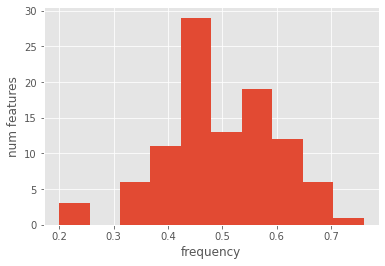

In [193]:
gamma_means = jnp.mean(mixed_sgmcmc.states_.discrete_position, axis=0)
gamma_means_idx_s = np.argsort(gamma_means)[::-1]
plt.hist(gamma_means)
plt.xlabel("frequency")
plt.ylabel("num features")

In [241]:
%autoreload
from tqdm import tqdm
from sgmcmc import MixedSGMCMC
from run_nn_fisher_test_exp import run_logistic_regression

X, y = data_dfs[seed_idx].iloc[:,:-1].to_numpy().astype(float), \
       data_dfs[seed_idx].iloc[:,-1].to_numpy().astype(float)

net = net_dfs[seed_idx].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, stratify=y, test_size=0.3)

X_train, X_test, y_train, y_test = jax.device_put(X_train), jax.device_put(X_test), \
                                   jax.device_put(y_train), jax.device_put(y_test)


rand_v_bnn_sel_fts_dict = {"seed": [], "feat_sel": [], "num_feats": [], "cv_score": [], "test_score": []}

all_feats = np.arange(p - 1)

feat_lens = [5, 10, 15]

cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
log_best_params, _, _ = run_logistic_regression(X_train, X_test, y_train, y_test, cv, verbose=0)
print(log_best_params)
log_clf = LogisticRegression(max_iter=10000, **log_best_params)
log_clf.fit(X_train, y_train)

log_coef = log_clf.coef_[0]

log_coef_sorted = np.argsort(log_coef)[::-1]

# # print(gamma_means)
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, stratify=y, test_size=0.3)

rng_key = jax.random.PRNGKey(seed)

for ft_len in feat_lens:
    # rand_sel_fts = jax.random.choice(rng_key, all_feats, (ft_len,), replace=False)
    #
    # X_train_rand_sel, X_test_rand_sel = X_train[:,rand_sel_fts], X_test[:,rand_sel_fts]
    #
    # _, rand_cv_score, rand_test_score = run_logistic_regression(X_train_rand_sel, X_test_rand_sel,
    #                                                            y_train, y_test, cv, verbose=0)
    #
    # log_sel_fts = log_coef_sorted[:ft_len]
    #
    # X_train_log_sel, X_test_log_sel, = X_train[:,log_sel_fts], X_test[:,log_sel_fts]
    #
    # _, log_cv_score, log_test_score = run_logistic_regression(X_train_log_sel, X_test_log_sel,
    #                                                          y_train, y_test, cv, verbose=0)

    bnn_sel_fts = gamma_means_idx_s[:ft_len]

    X_train_sel, X_test_sel = X_train[:,bnn_sel_fts], X_test[:,bnn_sel_fts]

    _, bnn_cv_score, bnn_test_score = run_logistic_regression(X_train_sel, X_test_sel,
                                                     y_train, y_test, cv, verbose=0)

    # rand_v_bnn_sel_fts_dict["seed"].append(seed)
    # rand_v_bnn_sel_fts_dict["feat_sel"].append("random")
    # rand_v_bnn_sel_fts_dict["num_feats"].append(ft_len)
    # rand_v_bnn_sel_fts_dict["cv_score"].append(rand_cv_score)
    # rand_v_bnn_sel_fts_dict["test_score"].append(rand_test_score)


    rand_v_bnn_sel_fts_dict["seed"].append(seed)
    rand_v_bnn_sel_fts_dict["feat_sel"].append("bnn")
    rand_v_bnn_sel_fts_dict["num_feats"].append(ft_len)
    rand_v_bnn_sel_fts_dict["cv_score"].append(bnn_cv_score)
    rand_v_bnn_sel_fts_dict["test_score"].append(bnn_test_score)

        # rand_v_bnn_sel_fts_dict["seed"].append(seed)
        # rand_v_bnn_sel_fts_dict["feat_sel"].append("lr")
        # rand_v_bnn_sel_fts_dict["num_feats"].append(ft_len)
        # # rand_v_bnn_sel_fts_dict["kernel"].append(svm_log_params["kernel"])
        # rand_v_bnn_sel_fts_dict["cv_score"].append(log_cv_score)
        # rand_v_bnn_sel_fts_dict["test_score"].append(log_test_score)


rand_v_bnn_sel_fts_df = pd.DataFrame(rand_v_bnn_sel_fts_dict)
rand_v_bnn_sel_fts_df

{'C': 0.046415888336127774}


,seed,feat_sel,num_feats,cv_score,test_score
0,220,bnn,5,0.503485,0.516591
1,220,bnn,10,0.681925,0.677579
2,220,bnn,15,0.693534,0.665701


### Variable Elimination

In [24]:
%autoreload
from operator import itemgetter
from tqdm import tqdm

def evaluate_bnn(model, X, y, params, gammas):
    eval_fn = lambda p, g: model.apply(p, X, g).ravel()
    logits = jax.vmap(eval_fn)(params, gammas)
    logits = logits.reshape(-1, logits.shape[-1])
    losses = jax.vmap(optax.sigmoid_binary_cross_entropy, in_axes=(0, None))(logits, y)
    mean_loss = jnp.mean(losses, axis=-1)
    return jnp.sum(mean_loss)

def get_feats_dropout_loss(sgmcmc, X, y):
    var_loss_dict = {"feats_idx": [], "num_models": [] , "loss_on": [], "loss_off": [], "loss_diff": []}
    # disc_states = sgmcmc.states_.discrete_position.reshape(-1, sgmcmc.states_.discrete_position.shape[-1])
    disc_states = sgmcmc.states_.discrete_position
    contin_states = tree_utils.tree_unstack(sgmcmc.states_.contin_position)

    num_models = disc_states.shape[0]

    p = X.shape[1]

    for idx in range(p):
        # idx = feats_idx[i]
        idx_on = np.argwhere(disc_states[:,idx] == 1.).ravel()
        loss_on, loss_off = 0., 0.
        if idx_on.size == 0: ## irrelevant feature
            loss_diff = 1e9
        else:
            disc_states_on = disc_states[idx_on]
            if idx_on.size > 1:
                params_on = tree_utils.tree_stack(itemgetter(*idx_on)(contin_states))
            else:
                params_on = tree_utils.tree_stack([contin_states[idx_on[0]]])
            loss_on = evaluate_bnn(sgmcmc.model_, X, y, params_on, disc_states_on)

            # Turn-off the variable, and see hwo the loss changes
            disc_states_off = disc_states_on.at[:,idx].set(0)
            loss_off = evaluate_bnn(sgmcmc.model_, X, y, params_on, disc_states_off)

            loss_diff = (loss_on - loss_off) * (len(idx_on) / num_models)


        var_loss_dict["feats_idx"].append(idx)
        var_loss_dict["num_models"].append(idx_on.size)
        var_loss_dict["loss_on"].append(loss_on)
        var_loss_dict["loss_off"].append(loss_off)
        var_loss_dict["loss_diff"].append(loss_diff)


    var_loss_df = pd.DataFrame(var_loss_dict).sort_values(by="loss_diff")

    return var_loss_df

In [107]:
save_dir_100 = f"{data_dir}/exp_data_4/bmm/f100"
dropout_loss_df = pd.read_csv(f"{save_dir_100}/drop_out_loss_s_{seed}.csv")

In [236]:
dropout_loss_df = get_feats_dropout_loss(mixed_sgmcmc, X_train, y_train)

In [237]:
dropout_loss_df

,feats_idx,num_models,loss_on,loss_off,loss_diff
91,91,100,49.446518,69.27913,-19.832611
57,57,100,49.446518,57.379875,-7.9333572
92,92,98,48.346237,50.37117,-1.9844342
80,80,100,49.446518,50.738968,-1.29245
26,26,100,49.446518,50.721832,-1.2753143
...,...,...,...,...,...
38,38,0,0.0,0.0,1000000000.0
36,36,0,0.0,0.0,1000000000.0
34,34,0,0.0,0.0,1000000000.0
44,44,0,0.0,0.0,1000000000.0


##### Logistic Regression

In [249]:
num_fts = 5
X_out_val_sel, X_test_sel = X_out_val[:,log_coef_sorted[:num_fts]], X_test[:,log_coef_sorted[:num_fts]]

_, val_score, test_score = run_logistic_regression(X_out_val_sel, X_test_sel, y_out_val, y_test, cv)
print(val_score)
print(test_score)

0.7195774231678488
0.6639384991227146


In [250]:
log_coef_sorted[:num_fts]

array([57, 91, 19,  5, 97])

In [251]:
from run_nn_fisher_test_exp import run_logistic_regression
feats_sel = dropout_loss_df["feats_idx"][:num_fts].to_list()

X_train_val_comb, X_test_sel = np.concatenate([X_train, X_out_val], axis=0)[:,feats_sel], X_test[:,feats_sel]
y_train_val_comb = np.concatenate([y_train, y_out_val], axis=0)

_, val_score, test_score = run_logistic_regression(X_train_val_comb, X_test_sel, y_train_val_comb, y_test, cv)
print(val_score)
print(test_score)

0.7056997899902273
0.6538351085134253


In [252]:
feats_sel

[91, 57, 92, 80, 26]

### GP Learn

In [253]:
# ft_len = 20
# sel_idx = gamma_means_idx_s[:feats_sel]
# sel_idx = log_coef_sorted[:ft_len]
X_gp_train, X_gp_val, X_gp_test = X_out_val[:,feats_sel].astype(int), X_train[:,feats_sel].astype(int), X_test[:,feats_sel].astype(int)
X_gp_train.shape

(315, 5)

In [14]:
from gplearn.genetic import SymbolicTransformer, SymbolicClassifier
from gplearn.functions import make_function
import operator


def get_best_programs(gp, num_models, ascending=True, sort_fit="OOB_fitness"):
    gp_dict = {'Gen': [], "Ind": [], "Fitness": [], 'OOB_fitness': []}

    for idGen in range(len(gp._programs)):
        for idPopulation in range(gp.population_size):
            if (gp._programs[idGen][idPopulation] != None):
                gp_dict["Gen"].append(idGen)
                gp_dict["Ind"].append(idPopulation)
                gp_dict["Fitness"].append(gp._programs[idGen][idPopulation].fitness_)
                gp_dict["OOB_fitness"].append(gp._programs[idGen][idPopulation].oob_fitness_)

    gp_df = pd.DataFrame(gp_dict).sort_values(sort_fit, ascending=ascending)[:num_models]
    programs = []
    for i in range(num_models):
        gen, ind = int(gp_df.iloc[i]["Gen"]), int(gp_df.iloc[i]["Ind"])
        programs.append(gp._programs[gen][ind])

    return programs


def gp_transform(est, X, classifier=False, num_models=100, sort_fit="Fitness"):
    if classifier:
        programs = get_best_programs(gp, num_models, classifier, sort_fit)
        out = np.zeros((X.shape[0], len(programs)))
        for i, prog in enumerate(programs):
            out[:, i] = prog.execute(X)

        return out

    return est.transform(X)


function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min']

In [255]:
def and_(x1, x2):
    return np.logical_and(x1, x2)

def or_(x1, x2):
    return np.logical_or(x1, x2)

def xor_(x1, x2):
    return np.logical_xor(x1, x2)

def not_(x1):
    return np.logical_not(x1)

# def if_else_then(x1, x2, x3):
#     if x1: return x2
#     return x3

# and_op = make_function(function=and_, name="and_", arity=2)
# or_op = make_function(function=or_, name="or_", arity=2)
# xor_op = make_function(function=xor_, name="xor_", arity=2)
# not_op = make_function(function=not_, name="not_", arity=1)
# if_else_op = make_function(function=if_else_then, name="if_else_", arity=3)

# function_set = [and_op, or_op, xor_op, not_op]

# gp = SymbolicTransformer(generations=500, population_size=1000, hall_of_fame=100, n_components=10,
#                          function_set=function_set, parsimony_coefficient=0.003,
#                          random_state=seed, max_samples=0.8, verbose=1,
#                          p_crossover=0.7, p_subtree_mutation=0.1, p_hoist_mutation=0.01,
#                          p_point_mutation=0.1, p_point_replace=0.05, metric="spearman")

gp = SymbolicClassifier(generations=500, population_size=1000,
                         function_set=function_set, parsimony_coefficient=0.001,
                         random_state=seed, max_samples=0.8, verbose=1,
                         p_crossover=0.7, p_subtree_mutation=0.1, p_hoist_mutation=0.01,
                         p_point_mutation=0.1, p_point_replace=0.05)

gp.fit(X_gp_train, y_out_val)

gp_features_val = gp_transform(gp, X_gp_val, classifier=True, sort_fit="Fitness")
gp_features_test = gp_transform(gp, X_gp_test, classifier=True, sort_fit="Fitness")

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    12.92         0.830495        6         0.509506         0.620272      4.09m
   1     7.96         0.603489       14         0.477057         0.795524      3.97m
   2     7.89         0.579677        3          0.46723         0.713685      3.85m
   3     6.19          0.55804        8         0.458254         0.749588      3.94m
   4     4.94         0.548983        3         0.469974         0.702709      3.86m
   5     4.26          0.54693        3         0.470216         0.701739      3.82m
   6     3.95         0.545346        4         0.449821         0.783321      3.79m
   7     3.90          0.54423        5          0.46667         0.768218      3.75m
   8     3.60         0.544013        5         0.463704         0.780081  

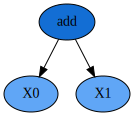

In [258]:
import graphviz
dot_data = gp._programs[-1][0].export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [260]:
from run_nn_fisher_test_exp import run_logistic_regression
 
X_val_comb, X_test_comb = np.concatenate([X_gp_val, gp_features_val], axis=1), np.concatenate([X_gp_test, gp_features_test], axis=1)

cv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

log_best_param_1, log_cv_score_1, log_test_score_1 = run_logistic_regression(X_val_comb, X_test_comb, y_train,
                                                                             y_test, cv)
print(f"Param: {log_best_param_1}, cv_score: {log_cv_score_1}, test_score: {log_test_score_1}")

Param: {'C': 0.021544346900318832}, cv_score: 0.7172214878019469, test_score: 0.692303693586838


In [265]:
gp_df_sorted = gp_df.sort_values('Fitness', ascending=True)[:5]
gp_df_sorted

,Gen,Ind,Fitness,OOB_fitness,Equation
2900,37,79,0.445167,0.813935,"add(X0, X1)"
36637,467,648,0.446071,0.870615,"add(add(X0, X1), X1)"
2273,29,355,0.446149,0.810007,"add(X0, X1)"
6758,86,705,0.447160,0.805965,"add(X0, X1)"
15537,200,822,0.447335,0.865558,"add(add(X0, X1), X1)"


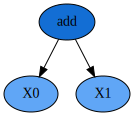

In [266]:
top_row = gp_df_sorted.iloc[2]
program = gp._programs[int(top_row["Gen"])][int(top_row["Ind"])]
dot_data = program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [267]:
from run_nn_fisher_test_exp import run_logistic_regression

gp_features_val = np.zeros((X_gp_val.shape[0], gp_df_sorted.shape[0]))
gp_features_test = np.zeros((X_gp_test.shape[0], gp_df_sorted.shape[0]))

for i in range(gp_df_sorted.shape[0]):
    row = gp_df_sorted.iloc[i]
    gen, ind = row["Gen"], row["Ind"]
    prog = gp._programs[gen][ind]
    val_out = prog.execute(X_gp_val)
    test_out = prog.execute(X_gp_test)

    gp_features_val[:,i] = val_out
    gp_features_test[:,i] = test_out

X_val_comb, X_test_comb = np.concatenate([X_gp_val, gp_features_val], axis=1), np.concatenate([X_gp_test, gp_features_test], axis=1)

cv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

log_best_param_1, log_cv_score_1, log_test_score_1 = run_logistic_regression(X_val_comb, X_test_comb, y_train,
                                                                            y_test, cv)
print(f"Param: {log_best_param_1}, cv_score: {log_cv_score_1}, test_score: {log_test_score_1}")
# clf_1 = LogisticRegression(max_iter=10000, **log_best_param_1)
# clf_1.fit(X_train_comb, y_train)

Param: {'C': 0.1}, cv_score: 0.7144093258021872, test_score: 0.6929302588089644


In [160]:
gp_features_val.shape

(1050, 10)

### Multiple Runs

#### BNN Runs

In [19]:
%autoreload
import pickle
from tqdm import tqdm
import warnings
from nn_util import prepare_data
from sgmcmc import MixedSGMCMC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")

save_dir_100 = f"{data_dir}/exp_data_4/bmm/f100"

bnn_lr_dict_100 = {"seed": [], "classifier": [], "cv_score": [], "test_score": []}

log_param_grid = {"C":np.logspace(-2, 1, 10)}

for i in range(len(seeds)):

    seed, net, data = prepare_data(seeds, i, data_dfs, net_dfs, test_size=0.3, out_val_size=0.5)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    print(f"Running - seed {seed}")

    X_train, _, X_test, y_train, _, y_test = data

    rng_key = jax.random.PRNGKey(seed)

    X_train, X_test, y_train, y_test = jax.device_put(X_train), jax.device_put(X_test), \
                                       jax.device_put(y_train), jax.device_put(y_test)


    log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=0, scoring="roc_auc", cv=cv).fit(X_train, y_train)
    log_cv_score = log_grid_cv.best_score_
    clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
    clf.fit(X_train, y_train)
    log_test_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

    config, bnn_cv_score, _ = optimize_hyper_parameters(seed, X_train, y_train, total_time=180)
    # config = pickle.load(open(f"{save_dir_100}/bnn_params_s_{seed}.pickle", "rb"))

    params = {"disc_lr": config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": config["batch_size"],
              "mu": config["mu"], "eta": config["eta"], "temp": config["temp"],
              "sigma": config["sigma"], "thinning_interval": config["thinning_interval"]}

    mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=5000, n_warmup=1000, n_chains=5, lr_schedule="exponential",
                     layer_dims=[config["layer_dim"]] ,**params)

    # bnn_cv_score = np.mean(cross_val_score(mixed_sgmcmc, X_train, y_train, cv=cv,
    #                                        fit_params={"activation_fns": [config["activation"]],  "J": net}))

    mixed_sgmcmc.fit(X_train, y_train, activation_fns=[config["activation"]], J=net)

    pickle.dump(config, open(f"{save_dir_100}/bnn_params_s_{seed}.pickle", "wb"))

    bnn_test_score = mixed_sgmcmc.score(X_test, y_test)

    bnn_disc_mean = jnp.mean(mixed_sgmcmc.states_.discrete_position.reshape(-1, X_train.shape[1]), axis=0)
    np.save(f"{save_dir_100}/bnn_disc_mean_s_{seed}.npy", bnn_disc_mean)


    bnn_lr_dict_100["seed"].append(seed)
    bnn_lr_dict_100["classifier"].append("LR")
    bnn_lr_dict_100["cv_score"].append(log_cv_score)
    bnn_lr_dict_100["test_score"].append(log_test_score)

    bnn_lr_dict_100["seed"].append(seed)
    bnn_lr_dict_100["classifier"].append("BNN")
    bnn_lr_dict_100["cv_score"].append(bnn_cv_score)
    bnn_lr_dict_100["test_score"].append(bnn_test_score)

    print(f"Config: {config}")

    print(f"Done - seed {seed}\nLR cv_score: {log_cv_score}, LR test_score: {log_test_score}")
    print(f"BNN cv_score: {bnn_cv_score}, BNN test_score: {bnn_test_score}")

bnn_lr_df_100 = pd.DataFrame(bnn_lr_dict_100)
bnn_lr_df_100.to_csv(f"{save_dir_100}/res_bmm_summary.csv", index=False)

Running - seed 422


Config: Configuration(values={
  'activation': 'tanh',
  'batch_size': 32,
  'contin_lr': 1e-05,
  'disc_lr': 0.1,
  'eta': 100.0,
  'layer_dim': 50,
  'mu': 0.1,
  'sigma': 0.001,
  'temp': 0.01,
  'thinning_interval': 200,
})

Done - seed 422
LR cv_score: 0.7526809392222926, LR test_score: 0.7613559994776149
BNN cv_score: 0.654884294602813, BNN test_score: 0.6084469373643162
Running - seed 261


Config: Configuration(values={
  'activation': 'relu',
  'batch_size': 256,
  'contin_lr': 0.001,
  'disc_lr': 0.1,
  'eta': 5,
  'layer_dim': 60,
  'mu': 0.1,
  'sigma': 0.1,
  'temp': 1.0,
  'thinning_interval': 50,
})

Done - seed 261
LR cv_score: 0.7433300345227697, LR test_score: 0.731235310215496
BNN cv_score: 0.7420122018349963, BNN test_score: 0.6935546155488364
Running - seed 968


Config: Configuration(values={
  'activation': 'relu',
  'batch_size': 128,
  'contin_lr': 1e-05,
  'disc_lr': 0.0001,
  'eta': 50.0,
  'layer_dim': 60,
  'mu': 1.0,
  'sigma': 10.0,
  'temp': 0.5,
  'thinning_interval': 200,
})

Done - seed 968
LR cv_score: 0.6231194870292615, LR test_score: 0.6331168581382143
BNN cv_score: 0.5805510280431017, BNN test_score: 0.551836072792582
Running - seed 282


Config: Configuration(values={
  'activation': 'relu',
  'batch_size': 128,
  'contin_lr': 1e-05,
  'disc_lr': 0.0001,
  'eta': 1.0,
  'layer_dim': 60,
  'mu': 5,
  'sigma': 0.1,
  'temp': 0.001,
  'thinning_interval': 50,
})

Done - seed 282
LR cv_score: 0.7471289274106175, LR test_score: 0.6055045370647242
BNN cv_score: 0.6020570137026444, BNN test_score: 0.6607142390627171
Running - seed 739


Config: Configuration(values={
  'activation': 'relu',
  'batch_size': 128,
  'contin_lr': 0.0001,
  'disc_lr': 0.01,
  'eta': 1.0,
  'layer_dim': 60,
  'mu': 100.0,
  'sigma': 0.1,
  'temp': 0.5,
  'thinning_interval': 150,
})

Done - seed 739
LR cv_score: 0.7632244008714598, LR test_score: 0.7416620269634149
BNN cv_score: 0.7112418447571254, BNN test_score: 0.7111668557917398
Running - seed 573


Config: Configuration(values={
  'activation': 'tanh',
  'batch_size': 64,
  'contin_lr': 0.001,
  'disc_lr': 0.01,
  'eta': 50.0,
  'layer_dim': 60,
  'mu': 100.0,
  'sigma': 0.1,
  'temp': 0.5,
  'thinning_interval': 150,
})

Done - seed 573
LR cv_score: 0.7532685584669169, LR test_score: 0.7599139543242561
BNN cv_score: 0.6862271855029914, BNN test_score: 0.6583894418550407
Running - seed 220


Config: Configuration(values={
  'activation': 'relu',
  'batch_size': 64,
  'contin_lr': 0.001,
  'disc_lr': 1e-05,
  'eta': 10.0,
  'layer_dim': 50,
  'mu': 5,
  'sigma': 10.0,
  'temp': 1.0,
  'thinning_interval': 200,
})

Done - seed 220
LR cv_score: 0.7141653843826707, LR test_score: 0.6964807962228895
BNN cv_score: 0.731101220624186, BNN test_score: 0.6823569452260736
Running - seed 413


Config: Configuration(values={
  'activation': 'relu',
  'batch_size': 32,
  'contin_lr': 0.0001,
  'disc_lr': 0.5,
  'eta': 100.0,
  'layer_dim': 70,
  'mu': 5,
  'sigma': 1.0,
  'temp': 0.5,
  'thinning_interval': 200,
})

Done - seed 413
LR cv_score: 0.8182599003409388, LR test_score: 0.7740667702713354
BNN cv_score: 0.7717952151839372, BNN test_score: 0.6843033891435664
Running - seed 745


Config: Configuration(values={
  'activation': 'tanh',
  'batch_size': 64,
  'contin_lr': 0.001,
  'disc_lr': 0.1,
  'eta': 100.0,
  'layer_dim': 50,
  'mu': 0.1,
  'sigma': 0.1,
  'temp': 1.0,
  'thinning_interval': 50,
})

Done - seed 745
LR cv_score: 0.7897502153316107, LR test_score: 0.7955350483887943
BNN cv_score: 0.7729543396347972, BNN test_score: 0.7088837254920194
Running - seed 775


Config: Configuration(values={
  'activation': 'tanh',
  'batch_size': 64,
  'contin_lr': 0.001,
  'disc_lr': 0.001,
  'eta': 1.0,
  'layer_dim': 70,
  'mu': 1.0,
  'sigma': 1.0,
  'temp': 1.0,
  'thinning_interval': 50,
})

Done - seed 775
LR cv_score: 0.8565464895635675, LR test_score: 0.8316599105387472
BNN cv_score: 0.82333967219098, BNN test_score: 0.7970850097306962
Running - seed 482


Config: Configuration(values={
  'activation': 'relu',
  'batch_size': 256,
  'contin_lr': 0.0001,
  'disc_lr': 0.001,
  'eta': 0.1,
  'layer_dim': 50,
  'mu': 10.0,
  'sigma': 1.0,
  'temp': 0.1,
  'thinning_interval': 150,
})

Done - seed 482
LR cv_score: 0.6728028189693143, LR test_score: 0.7894170664874678
BNN cv_score: 0.6488033846294388, BNN test_score: 0.5846048476981918
Running - seed 442


Config: Configuration(values={
  'activation': 'tanh',
  'batch_size': 128,
  'contin_lr': 0.001,
  'disc_lr': 0.0001,
  'eta': 100.0,
  'layer_dim': 60,
  'mu': 5,
  'sigma': 1.0,
  'temp': 0.5,
  'thinning_interval': 50,
})

Done - seed 442
LR cv_score: 0.7262328722644329, LR test_score: 0.7734746795337828
BNN cv_score: 0.6597835855730092, BNN test_score: 0.6779973913933917
Running - seed 210


Config: Configuration(values={
  'activation': 'tanh',
  'batch_size': 256,
  'contin_lr': 0.001,
  'disc_lr': 0.01,
  'eta': 5,
  'layer_dim': 60,
  'mu': 100.0,
  'sigma': 0.1,
  'temp': 0.5,
  'thinning_interval': 200,
})

Done - seed 210
LR cv_score: 0.7197629793961648, LR test_score: 0.7499665224290342
BNN cv_score: 0.5895525196299453, BNN test_score: 0.60488371063054
Running - seed 423


Config: Configuration(values={
  'activation': 'tanh',
  'batch_size': 32,
  'contin_lr': 0.001,
  'disc_lr': 1e-05,
  'eta': 5,
  'layer_dim': 70,
  'mu': 5,
  'sigma': 0.1,
  'temp': 0.5,
  'thinning_interval': 200,
})

Done - seed 423
LR cv_score: 0.7061500092614644, LR test_score: 0.7146685302917628
BNN cv_score: 0.6109080930132599, BNN test_score: 0.6425576158268984
Running - seed 760


Config: Configuration(values={
  'activation': 'tanh',
  'batch_size': 256,
  'contin_lr': 0.0001,
  'disc_lr': 0.1,
  'eta': 10.0,
  'layer_dim': 50,
  'mu': 1.0,
  'sigma': 0.1,
  'temp': 1.0,
  'thinning_interval': 150,
})

Done - seed 760
LR cv_score: 0.7353473373871384, LR test_score: 0.7261113993530636
BNN cv_score: 0.6782626905910922, BNN test_score: 0.7258559002768962
Running - seed 57


Config: Configuration(values={
  'activation': 'tanh',
  'batch_size': 128,
  'contin_lr': 0.0001,
  'disc_lr': 0.5,
  'eta': 0.1,
  'layer_dim': 50,
  'mu': 1.0,
  'sigma': 0.1,
  'temp': 0.001,
  'thinning_interval': 100,
})

Done - seed 57
LR cv_score: 0.585403579871665, LR test_score: 0.5901819901277701
BNN cv_score: 0.5248921659866045, BNN test_score: 0.4968860949622664
Running - seed 769


Config: Configuration(values={
  'activation': 'relu',
  'batch_size': 256,
  'contin_lr': 0.0001,
  'disc_lr': 1e-05,
  'eta': 0.1,
  'layer_dim': 50,
  'mu': 5,
  'sigma': 0.01,
  'temp': 0.5,
  'thinning_interval': 150,
})

Done - seed 769
LR cv_score: 0.7148747799771484, LR test_score: 0.7785897110201249
BNN cv_score: 0.621629698197817, BNN test_score: 0.6738378354271659
Running - seed 920


Config: Configuration(values={
  'activation': 'relu',
  'batch_size': 32,
  'contin_lr': 0.0001,
  'disc_lr': 0.001,
  'eta': 50.0,
  'layer_dim': 50,
  'mu': 10.0,
  'sigma': 1.0,
  'temp': 1.0,
  'thinning_interval': 100,
})

Done - seed 920
LR cv_score: 0.7871427052827948, LR test_score: 0.7797077553200249
BNN cv_score: 0.7166067723685469, BNN test_score: 0.6462986015301047
Running - seed 226


Config: Configuration(values={
  'activation': 'relu',
  'batch_size': 256,
  'contin_lr': 0.001,
  'disc_lr': 0.1,
  'eta': 100.0,
  'layer_dim': 50,
  'mu': 5,
  'sigma': 0.01,
  'temp': 0.5,
  'thinning_interval': 50,
})

Done - seed 226
LR cv_score: 0.661052871052871, LR test_score: 0.6615110578543569
BNN cv_score: 0.5281517694720195, BNN test_score: 0.4911105669259691
Running - seed 196


Config: Configuration(values={
  'activation': 'relu',
  'batch_size': 128,
  'contin_lr': 0.01,
  'disc_lr': 1e-05,
  'eta': 0.1,
  'layer_dim': 80,
  'mu': 50.0,
  'sigma': 0.1,
  'temp': 0.1,
  'thinning_interval': 50,
})

Done - seed 196
LR cv_score: 0.7542425416505232, LR test_score: 0.7379998380276886
BNN cv_score: 0.7350639235337624, BNN test_score: 0.7017308357671825


In [20]:
# bnn_lr_df.to_csv(f"{save_dir}/res_bmm_summary.csv", index=False)
bnn_lr_df_100 = pd.read_csv(f"{data_dir}/exp_data_4/bmm/f100/res_bmm_summary.csv")

In [22]:
bnn_lr_df_100.groupby(["classifier"])[["cv_score", "test_score"]].mean()

,cv_score,test_score
classifier,,
BNN,0.669491,0.650125
LR,0.731224,0.731608


#### Variable Selection

In [27]:
%autoreload
from tqdm import tqdm
from sgmcmc import MixedSGMCMC
from run_nn_fisher_test_exp import run_logistic_regression
import pickle
save_dir_100 = f"{data_dir}/exp_data_4/bmm/f100"
bnn_sel_fts_dict = {"seed": [], "feat_sel": [], "num_feats": [], "cv_score": [], "test_score": []}

all_feats = np.arange(p - 1)

feat_lens = [5, 10]

for i in tqdm(range(len(seeds))):

    seed, net, data = prepare_data(seeds, i, data_dfs, net_dfs, test_size=0.3)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    X_train, X_out_val, X_test, y_train, y_out_val, y_test = data

    rng_key = jax.random.PRNGKey(seed)

    X_train, X_test, y_train, y_test = jax.device_put(X_train), jax.device_put(X_test), \
                                       jax.device_put(y_train), jax.device_put(y_test)

    X_train_val_comb, y_train_val_comb = np.concatenate([X_train, X_out_val], axis=0), np.concatenate([y_train, y_out_val], axis=0)

    log_best_params, _, _ = run_logistic_regression(X_train, X_test, y_train, y_test, cv, verbose=0)
    log_clf = LogisticRegression(max_iter=10000, **log_best_params)
    log_clf.fit(X_train, y_train)

    log_coef = log_clf.coef_[0]

    log_coef_sorted = np.argsort(log_coef)[::-1]


    config = pickle.load(open(f"{save_dir_100}/bnn_params_s_{seed}.pickle", "rb"))
    params = {"disc_lr": config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": config["batch_size"],
              "mu": config["mu"], "eta": config["eta"], "temp": config["temp"],
              "sigma": config["sigma"], "thinning_interval": config["thinning_interval"]}

    mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=5000, n_warmup=1000, n_chains=5, lr_schedule="exponential",
                     layer_dims=[config["layer_dim"]] ,**params)

    # bnn_cv_score = np.mean(cross_val_score(mixed_sgmcmc, X_train, y_train, cv=cv,
    #                                        fit_params={"activation_fns": [config["activation"]],  "J": net}))

    mixed_sgmcmc.fit(X_train, y_train, activation_fns=[config["activation"]], J=net)

    gamma_means = jnp.mean(mixed_sgmcmc.states_.discrete_position.reshape(-1, X_train.shape[1]), axis=0)
    gamma_means_idx_s = np.argsort(gamma_means)[::-1]

    dropout_loss_df = get_feats_dropout_loss(mixed_sgmcmc, X_train, y_train)
    dropout_loss_df.to_csv(f"{save_dir_100}/drop_out_loss_s_{seed}.csv", index=False)

    for ft_len in feat_lens:

        log_sel_fts = log_coef_sorted[:ft_len]

        X_train_log_sel, X_test_log_sel, = X_train[:,log_sel_fts], X_test[:,log_sel_fts]

        _, log_cv_score, log_test_score = run_logistic_regression(X_train_log_sel, X_test_log_sel,
                                                                 y_train, y_test, cv, verbose=0)

        bnn_mean_sel = gamma_means_idx_s[:ft_len]

        X_train_sel_1, X_test_sel_1 = X_train_val_comb[:,bnn_mean_sel], X_test[:,bnn_mean_sel]

        _, bnn_cv_score_1, bnn_test_score_1 = run_logistic_regression(X_train_sel_1, X_test_sel_1,
                                                                  y_train_val_comb, y_test, cv, verbose=0)


        bnn_dropout_sel = dropout_loss_df["feats_idx"][:ft_len].to_list()

        X_train_sel_2, X_test_sel_2 = X_train_val_comb[:,bnn_dropout_sel], X_test[:,bnn_dropout_sel]

        _, bnn_cv_score_2, bnn_test_score_2 = run_logistic_regression(X_train_sel_2, X_test_sel_2,
                                                                      y_train_val_comb, y_test, cv, verbose=0)


        bnn_sel_fts_dict["seed"].append(seed)
        bnn_sel_fts_dict["feat_sel"].append("bnn_mean")
        bnn_sel_fts_dict["num_feats"].append(ft_len)
        bnn_sel_fts_dict["cv_score"].append(bnn_cv_score_1)
        bnn_sel_fts_dict["test_score"].append(bnn_test_score_1)

        bnn_sel_fts_dict["seed"].append(seed)
        bnn_sel_fts_dict["feat_sel"].append("bnn_dropout")
        bnn_sel_fts_dict["num_feats"].append(ft_len)
        bnn_sel_fts_dict["cv_score"].append(bnn_cv_score_2)
        bnn_sel_fts_dict["test_score"].append(bnn_test_score_2)

        bnn_sel_fts_dict["seed"].append(seed)
        bnn_sel_fts_dict["feat_sel"].append("lr")
        bnn_sel_fts_dict["num_feats"].append(ft_len)
        bnn_sel_fts_dict["cv_score"].append(log_cv_score)
        bnn_sel_fts_dict["test_score"].append(log_test_score)


bnn_sel_fts_df = pd.DataFrame(bnn_sel_fts_dict)
bnn_sel_fts_df.to_csv(f"{save_dir_100}/bnn_sel_feats_comparison.csv")

100%|██████████| 20/20 [16:19<00:00, 48.97s/it]


In [8]:
bnn_sel_fts_df = pd.read_csv(f"{save_dir_100}/bnn_sel_feats_comparison.csv")

In [28]:
bnn_sel_fts_df.groupby(["feat_sel", "num_feats"])[["cv_score", "test_score"]].mean()

cv_score  test_score
feat_sel    num_feats                      
bnn_dropout 5          0.699383    0.660715
            10         0.716268    0.691781
bnn_mean    5          0.554003    0.515844
            10         0.590296    0.540238
lr          5          0.739940    0.705963
            10         0.778950    0.746043

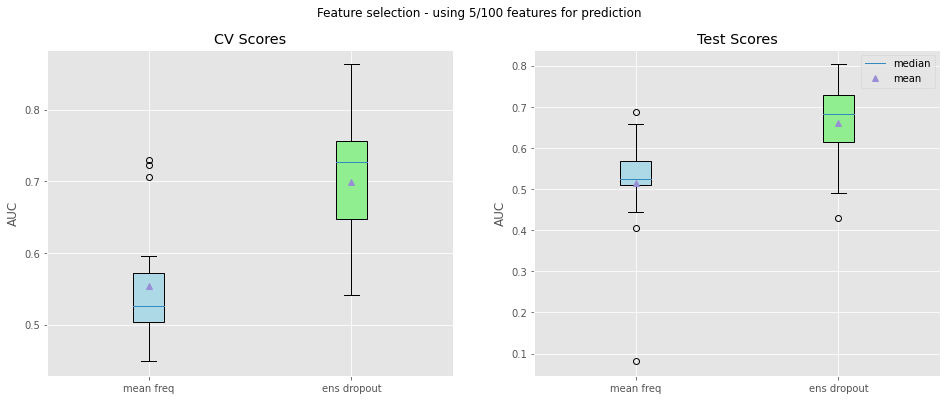

In [29]:
bnn_mean_5_cv_fts = bnn_sel_fts_df[(bnn_sel_fts_df["feat_sel"] == "bnn_mean") & (bnn_sel_fts_df["num_feats"] == 5)]["cv_score"].to_numpy()
bnn_dropout_5_cv_fts = bnn_sel_fts_df[(bnn_sel_fts_df["feat_sel"] == "bnn_dropout") & (bnn_sel_fts_df["num_feats"] == 5)]["cv_score"].to_numpy()

bnn_mean_5_test_fts = bnn_sel_fts_df[(bnn_sel_fts_df["feat_sel"] == "bnn_mean") & (bnn_sel_fts_df["num_feats"] == 5)]["test_score"].to_numpy()
bnn_dropout_5_test_fts = bnn_sel_fts_df[(bnn_sel_fts_df["feat_sel"] == "bnn_dropout") & (bnn_sel_fts_df["num_feats"] == 5)]["test_score"].to_numpy()

labels = ["mean freq", "ens dropout"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bplot1 = ax1.boxplot([bnn_mean_5_cv_fts, bnn_dropout_5_cv_fts], showmeans=True, patch_artist=True, labels=labels)
bplot2 = ax2.boxplot([bnn_mean_5_test_fts, bnn_dropout_5_test_fts], showmeans=True, patch_artist=True, labels=labels)

# fill with colors
colors = ['lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)


fig.suptitle("Feature selection - using 5/100 features for prediction")
plt.legend([bplot1['medians'][0], bplot1['means'][0]], ['median', 'mean'])
plt.legend([bplot2['medians'][0], bplot2['means'][0]], ['median', 'mean'])

ax1.set_ylabel("AUC")
ax1.set_title("CV Scores")

ax2.set_ylabel("AUC")
ax2.set_title("Test Scores")

plt.show()

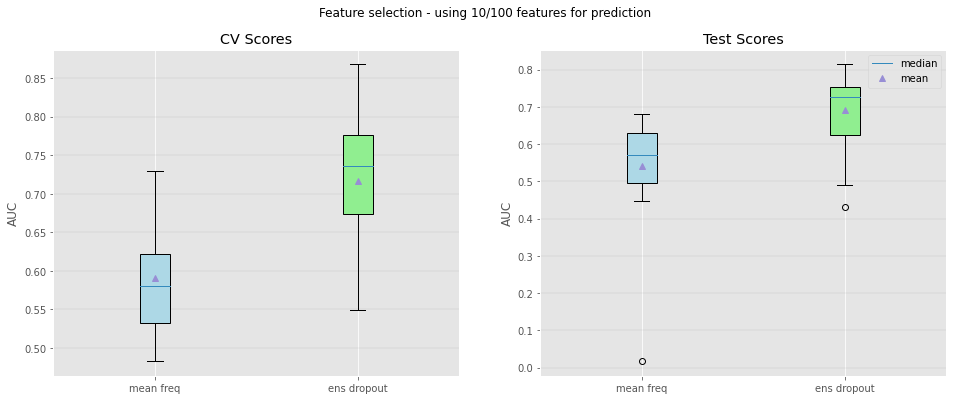

In [30]:
bnn_mean_10_cv_fts = bnn_sel_fts_df[(bnn_sel_fts_df["feat_sel"] == "bnn_mean") & (bnn_sel_fts_df["num_feats"] == 10)]["cv_score"].to_numpy()
bnn_dropout_10_cv_fts = bnn_sel_fts_df[(bnn_sel_fts_df["feat_sel"] == "bnn_dropout") & (bnn_sel_fts_df["num_feats"] == 10)]["cv_score"].to_numpy()

bnn_mean_10_test_fts = bnn_sel_fts_df[(bnn_sel_fts_df["feat_sel"] == "bnn_mean") & (bnn_sel_fts_df["num_feats"] == 10)]["test_score"].to_numpy()
bnn_dropout_10_test_fts = bnn_sel_fts_df[(bnn_sel_fts_df["feat_sel"] == "bnn_dropout") & (bnn_sel_fts_df["num_feats"] == 10)]["test_score"].to_numpy()

labels = ["mean freq", "ens dropout"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax2.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

bplot1 = ax1.boxplot([bnn_mean_10_cv_fts, bnn_dropout_10_cv_fts], showmeans=True, patch_artist=True, labels=labels)
bplot2 = ax2.boxplot([bnn_mean_10_test_fts, bnn_dropout_10_test_fts], showmeans=True, patch_artist=True, labels=labels)

# fill with colors
colors = ['lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

fig.suptitle("Feature selection - using 10/100 features for prediction")
plt.legend([bplot1['medians'][0], bplot1['means'][0]], ['median', 'mean'])

ax1.set_ylabel("AUC")
ax1.set_title("CV Scores")

ax2.set_ylabel("AUC")
ax2.set_title("Test Scores")

plt.show()

In [31]:
bnn_sel_fts_df

,seed,feat_sel,num_feats,cv_score,test_score
0,422,bnn_mean,5,0.527062,0.444663
1,422,bnn_dropout,5,0.706824,0.583225
2,422,lr,5,0.765435,0.778139
3,422,bnn_mean,10,0.531692,0.498160
4,422,bnn_dropout,10,0.705108,0.617021
...,...,...,...,...,...
115,196,bnn_dropout,5,0.742079,0.628625
116,196,lr,5,0.764026,0.723366
117,196,bnn_mean,10,0.728344,0.657789
118,196,bnn_dropout,10,0.742056,0.694357


#### GP

In [10]:
save_dir_100 = f"{data_dir}/exp_data_4/bmm/f100"

In [15]:
from gplearn.genetic import SymbolicTransformer, SymbolicClassifier
from gplearn.functions import make_function
import operator
from tqdm import tqdm
from run_nn_fisher_test_exp import run_logistic_regression

function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min']

bnn_gp_dict = {"seed": [], "orig_num_feats": [], "gp_num_feats": [] ,"classifier": [], "cv_score": [], "test_score": []}

feat_lens = [5, 10]

num_models = [5, 10, 20, 50]

for i in tqdm(range(len(seeds))):

    seed, net, data = prepare_data(seeds, i, data_dfs, net_dfs, test_size=0.3)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    X_train, X_out_val, X_test, y_train, y_out_val, y_test = data
   
    X_train_val_comb, y_train_val_comb = np.concatenate([X_train, X_out_val], axis=0), np.concatenate([y_train, y_out_val], axis=0)
    dropout_loss_df = pd.read_csv(f"{save_dir_100}/drop_out_loss_s_{seed}.csv")

    for ft_len in feat_lens:

        bnn_dropout_sel = dropout_loss_df["feats_idx"][:ft_len].to_list()
        X_train_sel_1, X_test_sel_1 = X_train_val_comb[:,bnn_dropout_sel], X_test[:,bnn_dropout_sel]

        _, bnn_cv_score_1, bnn_test_score_1 = run_logistic_regression(X_train_sel_1, X_test_sel_1,
                                                                      y_train_val_comb, y_test, cv, verbose=0)

        X_gp_train_sel, X_gp_val_sel, X_gp_test_sel = X_out_val[:,bnn_dropout_sel], X_train[:,bnn_dropout_sel] ,X_test[:,bnn_dropout_sel]

        gp = SymbolicClassifier(generations=500, population_size=1000,
                         function_set=function_set, parsimony_coefficient=0.001,
                         random_state=seed, max_samples=0.8, verbose=0,
                         p_crossover=0.7, p_subtree_mutation=0.1, p_hoist_mutation=0.01,
                         p_point_mutation=0.1, p_point_replace=0.05)

        # gp = SymbolicTransformer(generations=100, population_size=1000, hall_of_fame=100, n_components=20,
        #                          function_set=function_set, parsimony_coefficient=0.001,
        #                          random_state=seed, max_samples=0.8, verbose=0,
        #                          p_crossover=0.7, p_subtree_mutation=0.1, p_hoist_mutation=0.01,
        #                          p_point_mutation=0.1, p_point_replace=0.05, metric="spearman")

        gp.fit(X_gp_train_sel, y_out_val)

        gp_features_val_fit = gp_transform(gp, X_gp_val_sel, classifier=True, num_models=50, sort_fit="Fitness")
        gp_features_test_fit = gp_transform(gp, X_gp_test_sel, classifier=True, num_models=50, sort_fit="Fitness")

        gp_features_val_oob_fit = gp_transform(gp, X_gp_val_sel, classifier=True, num_models=50, sort_fit="OOB_fitness")
        gp_features_test_oob_fit = gp_transform(gp, X_gp_test_sel, classifier=True, num_models=50, sort_fit="OOB_fitness")

        best_cv_score_fit, best_test_score_fit = 0.0, 0.0
        best_cv_score_oob_fit, best_test_score_oob_fit = 0.0, 0.0
        best_n_models_fit, best_n_models_oob_fit = 0, 0
        for j in num_models:
            X_val_comb_fit, X_test_comb_fit = np.concatenate([X_gp_val_sel, gp_features_val_fit[:,:j]], axis=1), np.concatenate([X_gp_test_sel, gp_features_test_fit[:,:j]], axis=1)

            _, log_bnn_gp_cv_fit, log_bnn_gp_test_fit = run_logistic_regression(X_val_comb_fit, X_test_comb_fit, y_train,
                                                                                        y_test, cv)

            if log_bnn_gp_cv_fit > best_cv_score_fit:
                best_cv_score_fit = log_bnn_gp_cv_fit
                best_test_score_fit = log_bnn_gp_test_fit
                best_n_models_fit = j

            X_val_comb_oob_fit, X_test_comb_oob_fit = np.concatenate([X_gp_val_sel, gp_features_val_oob_fit[:,:j]], axis=1), np.concatenate([X_gp_test_sel, gp_features_test_oob_fit[:,:j]], axis=1)

            _, log_bnn_gp_cv_oob_fit, log_bnn_gp_test_oob_fit = run_logistic_regression(X_val_comb_oob_fit, X_test_comb_oob_fit, y_train,
                                                                                        y_test, cv)
            
            if log_bnn_gp_cv_oob_fit > best_cv_score_oob_fit:
                best_cv_score_oob_fit = log_bnn_gp_cv_oob_fit
                best_test_score_oob_fit = log_bnn_gp_test_oob_fit
                best_n_models_oob_fit = j

        bnn_gp_dict["seed"].append(seed)
        bnn_gp_dict["classifier"].append("BNN + LR")
        bnn_gp_dict["orig_num_feats"].append(ft_len)
        # bnn_gp_dict["gp_num_feats"].append(0)
        bnn_gp_dict["cv_score"].append(bnn_cv_score_1)
        bnn_gp_dict["test_score"].append(bnn_test_score_1)

        bnn_gp_dict["seed"].append(seed)
        bnn_gp_dict["classifier"].append("BNN + LR + GP1")
        bnn_gp_dict["orig_num_feats"].append(ft_len)
        bnn_gp_dict["gp_num_feats"].append(best_n_models_fit)
        bnn_gp_dict["cv_score"].append(best_cv_score_fit)
        bnn_gp_dict["test_score"].append(best_test_score_fit)

        bnn_gp_dict["seed"].append(seed)
        bnn_gp_dict["classifier"].append("BNN + LR + GP2")
        bnn_gp_dict["orig_num_feats"].append(ft_len)
        bnn_gp_dict["gp_num_feats"].append(best_n_models_oob_fit)
        bnn_gp_dict["cv_score"].append(best_cv_score_oob_fit)
        bnn_gp_dict["test_score"].append(best_test_score_oob_fit)



bnn_gp_df = pd.DataFrame(bnn_gp_dict)
bnn_gp_df.to_csv(f"{save_dir_100}/bnn_lr_gp.csv", index=False)

100%|██████████| 20/20 [2:55:09<00:00, 525.48s/it]  


ValueError: All arrays must be of the same length

In [18]:
gp_num_features = bnn_gp_dict["gp_num_feats"]

In [20]:
# bnn_gp_df = pd.DataFrame(bnn_gp_dict)
# bnn_gp_df.to_csv(f"{save_dir_100}/bnn_lr_gp.csv", index=False)

In [11]:
bnn_gp_df = pd.read_csv(f"{save_dir_100}/bnn_lr_gp.csv")
bnn_gp_df

,seed,orig_num_feats,classifier,cv_score,test_score
0,422,5,BNN + LR,0.706824,0.583225
1,422,5,BNN + LR + GP1,0.713262,0.583748
2,422,5,BNN + LR + GP2,0.712281,0.583769
3,422,10,BNN + LR,0.705108,0.617021
4,422,10,BNN + LR + GP1,0.718502,0.612253
...,...,...,...,...,...
115,196,5,BNN + LR + GP1,0.741399,0.695400
116,196,5,BNN + LR + GP2,0.741960,0.628377
117,196,10,BNN + LR,0.742056,0.694357
118,196,10,BNN + LR + GP1,0.738861,0.677255


In [12]:
bnn_gp_df.groupby(["classifier", "orig_num_feats"])[["cv_score", "test_score"]].mean()

cv_score  test_score
classifier     orig_num_feats                      
BNN + LR       5               0.699383    0.660807
               10              0.716268    0.691755
BNN + LR + GP1 5               0.706323    0.660795
               10              0.720339    0.685887
BNN + LR + GP2 5               0.710758    0.645503
               10              0.719304    0.686982

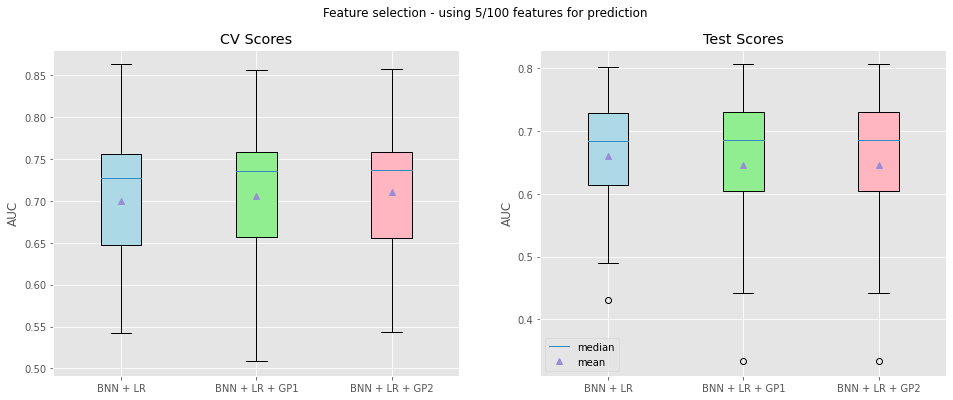

In [14]:
bnn_lr_cv_5_fts = bnn_gp_df[(bnn_gp_df["classifier"] == "BNN + LR") & (bnn_gp_df["orig_num_feats"] == 5)]["cv_score"].to_numpy()
bnn_gp_1_cv_5_fts = bnn_gp_df[(bnn_gp_df["classifier"] == "BNN + LR + GP1") & (bnn_gp_df["orig_num_feats"] == 5)]["cv_score"].to_numpy()
bnn_gp_2_cv_5_fts = bnn_gp_df[(bnn_gp_df["classifier"] == "BNN + LR + GP2") & (bnn_gp_df["orig_num_feats"] == 5)]["cv_score"].to_numpy()

bnn_lr_test_5_fts = bnn_gp_df[(bnn_gp_df["classifier"] == "BNN + LR") & (bnn_gp_df["orig_num_feats"] == 5)]["test_score"].to_numpy()
bnn_gp_1_test_5_fts = bnn_gp_df[(bnn_gp_df["classifier"] == "BNN + LR + GP2") & (bnn_gp_df["orig_num_feats"] == 5)]["test_score"].to_numpy()
bnn_gp_2_test_5_fts = bnn_gp_df[(bnn_gp_df["classifier"] == "BNN + LR + GP2") & (bnn_gp_df["orig_num_feats"] == 5)]["test_score"].to_numpy()

labels = ["BNN + LR", "BNN + LR + GP1", "BNN + LR + GP2"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bplot1 = ax1.boxplot([bnn_lr_cv_5_fts, bnn_gp_1_cv_5_fts, bnn_gp_2_cv_5_fts], showmeans=True, patch_artist=True, labels=labels)
bplot2 = ax2.boxplot([bnn_lr_test_5_fts, bnn_gp_1_test_5_fts, bnn_gp_2_test_5_fts], showmeans=True, patch_artist=True, labels=labels)

# fill with colors
colors = ['lightblue', 'lightgreen', "lightpink"]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)


fig.suptitle("Feature selection - using 5/100 features for prediction")
plt.legend([bplot1['medians'][0], bplot1['means'][0]], ['median', 'mean'])
plt.legend([bplot2['medians'][0], bplot2['means'][0]], ['median', 'mean'])

ax1.set_ylabel("AUC")
ax1.set_title("CV Scores")

ax2.set_ylabel("AUC")
ax2.set_title("Test Scores")

plt.show()

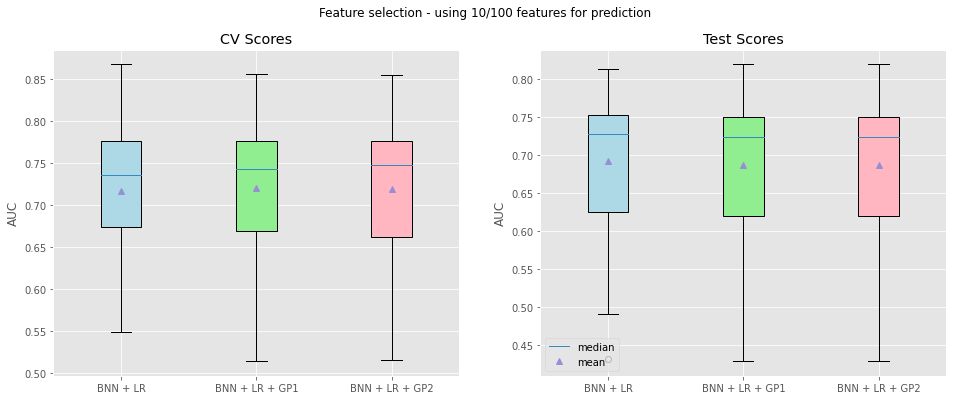

In [16]:
bnn_lr_cv_10_fts = bnn_gp_df[(bnn_gp_df["classifier"] == "BNN + LR") & (bnn_gp_df["orig_num_feats"] == 10)]["cv_score"].to_numpy()
bnn_gp_1_cv_10_fts = bnn_gp_df[(bnn_gp_df["classifier"] == "BNN + LR + GP1") & (bnn_gp_df["orig_num_feats"] == 10)]["cv_score"].to_numpy()
bnn_gp_2_cv_10_fts = bnn_gp_df[(bnn_gp_df["classifier"] == "BNN + LR + GP2") & (bnn_gp_df["orig_num_feats"] == 10)]["cv_score"].to_numpy()

bnn_lr_test_10_fts = bnn_gp_df[(bnn_gp_df["classifier"] == "BNN + LR") & (bnn_gp_df["orig_num_feats"] == 10)]["test_score"].to_numpy()
bnn_gp_1_test_10_fts = bnn_gp_df[(bnn_gp_df["classifier"] == "BNN + LR + GP2") & (bnn_gp_df["orig_num_feats"] == 10)]["test_score"].to_numpy()
bnn_gp_2_test_10_fts = bnn_gp_df[(bnn_gp_df["classifier"] == "BNN + LR + GP2") & (bnn_gp_df["orig_num_feats"] == 10)]["test_score"].to_numpy()

labels = ["BNN + LR", "BNN + LR + GP1", "BNN + LR + GP2"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bplot1 = ax1.boxplot([bnn_lr_cv_10_fts, bnn_gp_1_cv_10_fts, bnn_gp_2_cv_10_fts], showmeans=True, patch_artist=True, labels=labels)
bplot2 = ax2.boxplot([bnn_lr_test_10_fts, bnn_gp_1_test_10_fts, bnn_gp_2_test_10_fts], showmeans=True, patch_artist=True, labels=labels)

# fill with colors
colors = ['lightblue', 'lightgreen', "lightpink"]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)


fig.suptitle("Feature selection - using 10/100 features for prediction")
plt.legend([bplot1['medians'][0], bplot1['means'][0]], ['median', 'mean'])
plt.legend([bplot2['medians'][0], bplot2['means'][0]], ['median', 'mean'])

ax1.set_ylabel("AUC")
ax1.set_title("CV Scores")

ax2.set_ylabel("AUC")
ax2.set_title("Test Scores")

plt.show()

### Logistic Regression vs. BNN feat_size = 500

In [1]:
save_dir_500 = f"{data_dir}/exp_data_4/bmm/f500"

NameError: name 'data_dir' is not defined

In [39]:
%autoreload
import pickle
from tqdm import tqdm
import warnings
from nn_util import prepare_data
from sgmcmc import MixedSGMCMC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")



config_values = []

bnn_lr_dict_500 = {"seed": [], "classifier": [], "cv_score": [], "test_score": []}

log_param_grid = {"C":np.logspace(-2, 1, 10)}

for i in range(len(seeds)):

    seed, net, data = prepare_data(seeds, i, data_dfs, net_dfs, test_size=0.3)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    print(f"Running - seed {seed}")
    X_train, X_test, y_train, y_test = data
    rng_key = jax.random.PRNGKey(seed)

    X_train, X_test, y_train, y_test = jax.device_put(X_train), jax.device_put(X_test), \
                                       jax.device_put(y_train), jax.device_put(y_test)


    log_grid_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=log_param_grid, verbose=0, scoring="roc_auc", cv=cv).fit(X_train, y_train)
    log_cv_score = log_grid_cv.best_score_
    clf = LogisticRegression(max_iter=10000, C=log_grid_cv.best_params_["C"])
    clf.fit(X_train, y_train)
    log_test_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

    config, bnn_cv_score = optimize_hyper_parameters(seed, X_train, y_train)

    # config = pickle.load(open(f"{save_dir}/bnn_params_s_{seed}.pickle", "rb"))
    config_values.append(config)

    pickle.dump(config, open(f"{save_dir_500}/bnn_params_s_{seed}.pickle", "wb"))

    params = {"disc_lr": config["disc_lr"], "contin_lr": config["contin_lr"], "batch_size": config["batch_size"],
              "mu": config["mu"], "eta": config["eta"], "temp": config["temp"],
              "sigma": config["sigma"], "cycle_len": config["cycle_len"], "beta": config["beta"]}

    mixed_sgmcmc = MixedSGMCMC(seed=seed, n_samples=2000, n_warmup=0,
                               n_chains=1, layer_dims=[config["layer_dim"]], **params)

    # bnn_cv_score = np.mean(cross_val_score(mixed_sgmcmc, X_train, y_train, cv=cv,
    #                                        fit_params={"activation_fns": [config["activation"]],  "J": net}))

    mixed_sgmcmc.fit(X_train, y_train, activation_fns=[config["activation"]], J=net)

    bnn_test_score = mixed_sgmcmc.score(X_test, y_test)

    bnn_disc_mean = jnp.mean(mixed_sgmcmc.states_.discrete_position, axis=0)
    np.save(f"{save_dir_500}/bnn_disc_mean_s_{seed}.npy", bnn_disc_mean)


    bnn_lr_dict_500["seed"].append(seed)
    bnn_lr_dict_500["classifier"].append("LR")
    bnn_lr_dict_500["cv_score"].append(log_cv_score)
    bnn_lr_dict_500["test_score"].append(log_test_score)

    bnn_lr_dict_500["seed"].append(seed)
    bnn_lr_dict_500["classifier"].append("BNN")
    bnn_lr_dict_500["cv_score"].append(bnn_cv_score)
    bnn_lr_dict_500["test_score"].append(bnn_test_score)

    print(f"Config: {config}")

    print(f"Done - seed {seed}\nLR cv_score: {log_cv_score}, LR test_score: {log_test_score}")
    print(f"BNN cv_score: {bnn_cv_score}, BNN test_score: {bnn_test_score}")

bnn_lr_df_500 = pd.DataFrame(bnn_lr_dict_500)
bnn_lr_df_500.to_csv(f"{save_dir_500}/res_bmm_summary.csv", index=False)

Running - seed 422


KeyboardInterrupt: 

In [68]:
bnn_lr_df_500 = pd.read_csv(f"{save_dir_500}/res_bmm_summary.csv")
bnn_lr_df_500

,seed,classifier,cv_score,test_score
0,422,LR,0.558040,0.492985
1,422,BNN,0.525300,0.543771
2,261,LR,0.537980,0.549244
3,261,BNN,0.527738,0.529176
4,968,LR,0.552338,0.455197
5,968,BNN,0.508821,0.555556
6,282,LR,0.567325,0.502264
7,282,BNN,0.566687,0.534309
8,739,LR,0.677096,0.722995
9,739,BNN,0.676894,0.713584


In [10]:
bnn_lr_df_500.groupby(["classifier"])[["cv_score", "test_score"]].mean()

,cv_score,test_score
classifier,,
BNN,0.583961,0.539200
LR,0.589860,0.531072


In [120]:
config

Configuration(values={
  'activation': 'tanh',
  'batch_size': 64,
  'beta': 0.9901000815779375,
  'contin_lr': 0.000553849670496185,
  'disc_lr': 0.015499881752989718,
  'eta': 13.42890174428199,
  'layer_dim': 50,
  'mu': 355.8300138691474,
  'sigma': 6.261816495065096,
  'temp': 0.0040914487548523466,
})

In [100]:
rand_v_bnn_sel_fts_df.groupby(["feat_sel", "num_feats"])[["cv_score", "test_score"]].mean()

cv_score  test_score
feat_sel num_feats                      
bnn      5          0.508902    0.506224
         10         0.517699    0.511703
         15         0.517699    0.511703
random   5          0.523177    0.518667
         10         0.564427    0.578557
         15         0.566813    0.574128

Text(0, 0.5, 'num features')

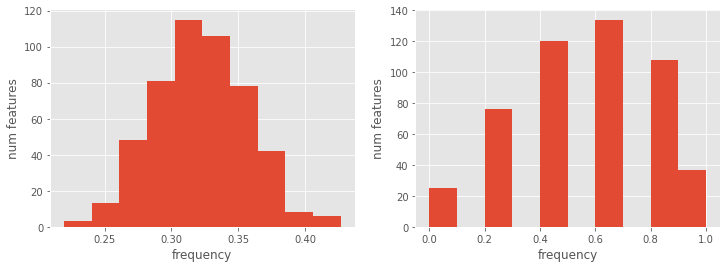

In [101]:
gamma_means = jnp.mean(mixed_sgmcmc.states_.discrete_position, axis=0)
bnn_disc_mean_s_442 = np.load(f"{save_dir_500}/bnn_disc_mean_s_{seed}.npy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(bnn_disc_mean_s_442)
ax1.set_xlabel("frequency")
ax1.set_ylabel("num features")

ax2.hist(gamma_means)
ax2.set_xlabel("frequency")
ax2.set_ylabel("num features")

In [ ]:
from scipy import stats
bnn_sel_ft_5 = rand_v_bnn_sel_fts_df[(rand_v_bnn_sel_fts_df["feat_sel"] == "bnn" ) & (rand_v_bnn_sel_fts_df["num_feats"] == 5)]
rand_fisher_sel_ft_5 = rand_v_bnn_sel_fts_df[(rand_v_bnn_sel_fts_df["feat_sel"] == "random") & (rand_v_bnn_sel_fts_df["num_feats"] == 5)]

bnn_sel_ft_10 = rand_v_bnn_sel_fts_df[(rand_v_bnn_sel_fts_df["feat_sel"] == "bnn" ) & (rand_v_bnn_sel_fts_df["num_feats"] == 10)]
rand_fisher_sel_ft_10 = rand_v_bnn_sel_fts_df[(rand_v_bnn_sel_fts_df["feat_sel"] == "random") & (rand_v_bnn_sel_fts_df["num_feats"] == 10)]

cv_score_bnn_sel_ft_5 = bnn_sel_ft_5["cv_score"]
cv_score_rand_sel_ft_5 = rand_fisher_sel_ft_5["cv_score"]

cv_score_bnn_sel_ft_10 = bnn_sel_ft_10["cv_score"]
cv_score_rand_sel_ft_10 = rand_fisher_sel_ft_10["cv_score"]

test_score_bnn_sel_ft_5 = bnn_sel_ft_5["test_score"]
test_score_rand_sel_ft_5 = rand_fisher_sel_ft_5["test_score"]

test_score_bnn_sel_ft_10 = bnn_sel_ft_10["test_score"]
test_score_rand_sel_ft_10 = rand_fisher_sel_ft_10["test_score"]

p_val_cv_score_5 = stats.ttest_ind(cv_score_bnn_sel_ft_5, cv_score_rand_sel_ft_5, alternative="two-sided", equal_var=False).pvalue
p_val_test_score_5 = stats.ttest_ind(test_score_bnn_sel_ft_5, test_score_rand_sel_ft_5, alternative="two-sided", equal_var=False).pvalue

p_val_cv_score_10 = stats.ttest_ind(cv_score_bnn_sel_ft_10, cv_score_rand_sel_ft_10, alternative="two-sided", equal_var=False).pvalue
p_val_test_score_10 = stats.ttest_ind(test_score_bnn_sel_ft_10, test_score_rand_sel_ft_5, alternative="two-sided", equal_var=False).pvalue

print("=========== Num feats: 5 =====================")
print(f"CV Scores: BNN vs Random - p_value (two-sided): {p_val_cv_score_5}")
print(f"Test Scores: BNN vs Random - p_value (two-sided): {p_val_test_score_5}")

print("\n=========== Num feats: 10 =====================")
print(f"CV Scores: BNN vs Random - p_value (two-sided): {p_val_cv_score_10}")
print(f"Test Scores: BNN vs Random - p_value (two-sided): {p_val_test_score_10}")

In [85]:
p_val_cv_score_5 = stats.ttest_ind(cv_score_bnn_sel_ft_5, cv_score_rand_sel_ft_5, alternative="greater", equal_var=False).pvalue
p_val_test_score_5 = stats.ttest_ind(test_score_bnn_sel_ft_5, test_score_rand_sel_ft_5, alternative="greater", equal_var=False).pvalue

p_val_cv_score_10 = stats.ttest_ind(cv_score_bnn_sel_ft_10, cv_score_rand_sel_ft_10, alternative="greater", equal_var=False).pvalue
p_val_test_score_10 = stats.ttest_ind(test_score_bnn_sel_ft_10, test_score_rand_sel_ft_5, alternative="greater", equal_var=False).pvalue

print("=========== Num feats: 5 =====================")
print(f"CV Scores: BNN vs Random - p_value (one-sided): {p_val_cv_score_5}")
print(f"Test Scores: BNN vs Random - p_value (one-sided): {p_val_test_score_5}")

print("\n=========== Num feats: 10 =====================")
print(f"CV Scores: BNN vs Random - p_value (one-sided): {p_val_cv_score_10}")
print(f"Test Scores: BNN vs Random - p_value (one-sided): {p_val_test_score_10}")

=========== Num feats: 5 =====================
CV Scores: BNN vs Random - p_value (one-sided): 9.539647905564428e-15
Test Scores: BNN vs Random - p_value (one-sided): 2.4414652092392635e-12

=========== Num feats: 10 =====================
CV Scores: BNN vs Random - p_value (one-sided): 2.301495416941404e-08
Test Scores: BNN vs Random - p_value (one-sided): 1.1606598065503922e-11


In [90]:
seeds[11]

442

In [50]:
%autoreload
import pickle
from sgmcmc import MixedSGMCMC
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
seed_idx = 4

seed = seeds[seed_idx]
X, y = data_dfs[seed_idx].iloc[:,:-1].to_numpy().astype(np.float),  \
       data_dfs[seed_idx].iloc[:,-1].to_numpy().astype(np.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, stratify=y, test_size=0.3)

X_train, X_test, y_train, y_test = jax.device_put(X_train), jax.device_put(X_test), \
                                   jax.device_put(y_train), jax.device_put(y_test)
net = net_dfs[seed_idx].to_numpy()

bnn_params_s_442 = pickle.load(open(f"{save_dir_500}/bnn_params_s_{seed}.pickle", "rb"))

print(bnn_params_s_442)

params = {"disc_lr": 0.1, "contin_lr": 0.001, "batch_size": bnn_params_s_442["batch_size"],
          "mu": 1000, "eta": 10, "temp": bnn_params_s_442["temp"],
          "sigma": bnn_params_s_442["sigma"], "cycle_len": 5, "beta": 0.95}

cv = StratifiedKFold(shuffle=True, random_state=seed)
mixed_sgmcmc = MixedSGMCMC(seed=442, n_samples=1000, n_warmup=0,
                           n_chains=1, layer_dims=[bnn_params_s_442["layer_dim"]], **params)

bnn_cv_score = np.mean(cross_val_score(mixed_sgmcmc, X_train, y_train, cv=cv,
                                       fit_params={"activation_fns": [bnn_params_s_442["activation"]],  "J": net}))

print(bnn_cv_score)
mixed_sgmcmc.fit(X_train, y_train, activation_fns=[bnn_params_s_442["activation"]], J=net)

print(mixed_sgmcmc.score(X_test, y_test))

/tmp/ipykernel_348/1906722657.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X, y = data_dfs[seed_idx].iloc[:,:-1].to_numpy().astype(np.float),  \
/tmp/ipykernel_348/1906722657.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_dfs[seed_idx].iloc[:,-1].to_numpy().astype(np.float)


Configuration(values={
  'activation': 'relu',
  'batch_size': 32,
  'beta': 0.9223176022517695,
  'contin_lr': 2.921565057716431e-05,
  'cycle_len': 7,
  'disc_lr': 0.0255358112072285,
  'eta': 0.15141244695593806,
  'layer_dim': 300,
  'mu': 0.5222315154956412,
  'sigma': 7.401408430020509,
  'temp': 0.09070826467316453,
})

0.5378787869760631
0.5632159934179469


In [51]:
len(mixed_sgmcmc.disc_states)

45

Text(0, 0.5, 'num features')

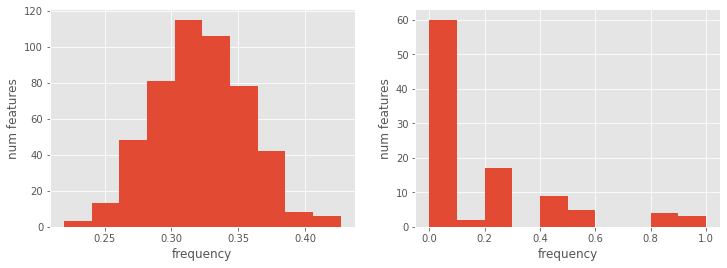

In [191]:
gamma_means = jnp.mean(mixed_sgmcmc.states_.discrete_position, axis=0)
bnn_disc_mean_s_442 = np.load(f"{save_dir_500}/bnn_disc_mean_s_{seed}.npy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(bnn_disc_mean_s_442)
ax1.set_xlabel("frequency")
ax1.set_ylabel("num features")

ax2.hist(gamma_means)
ax2.set_xlabel("frequency")
ax2.set_ylabel("num features")

In [195]:
%autoreload
from run_moses_cosmic_exp import run_logistc_regression
from tqdm import tqdm

seed_idx = 2
seed = seeds[seed_idx]
X, y = data_dfs[seed_idx].iloc[:,:-1].to_numpy().astype(np.float), \
       data_dfs[seed_idx].iloc[:,-1].to_numpy().astype(np.float)

net = net_dfs[seed_idx].to_numpy()

gamma_means_idx_s = np.argsort(gamma_means)[::-1]

log_v_bnn_sel_fts_dict = {"seed": [], "feat_sel": [], "num_feats": [], "cv_score": [], "test_score": []}

all_feats = np.arange(p - 1)

feat_lens = [5, 10]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, stratify=y, test_size=0.3)


cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
log_best_params, _, _ = run_logistc_regression(X_train, X_test, y_train, y_test, cv, verbose=0)
print(log_best_params)
log_clf = LogisticRegression(max_iter=10000, **log_best_params)
log_clf.fit(X_train, y_train)

log_coef = log_clf.coef_[0]

log_coef_sorted = np.argsort(log_coef)[::-1]

for seed in tqdm(seeds):

    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)

    # print(gamma_means)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, stratify=y, test_size=0.3)

    rng_key = jax.random.PRNGKey(seed)

    for ft_len in feat_lens:

        log_sel_fts = log_coef_sorted[:ft_len]

        X_train_log_sel, X_test_log_sel, = X_train[:,log_sel_fts], X_test[:,log_sel_fts]

        _, log_cv_score, log_test_score = run_logistc_regression(X_train_log_sel, X_test_log_sel,
                                                                 y_train, y_test, cv, verbose=0)

        bnn_sel_fts = gamma_means_idx_s[:ft_len]

        X_train_sel, X_test_sel = X_train[:,bnn_sel_fts], X_test[:,bnn_sel_fts]

        _, bnn_cv_score, bnn_test_score = run_logistc_regression(X_train_sel, X_test_sel,
                                                                 y_train, y_test, cv, verbose=0)


        log_v_bnn_sel_fts_dict["seed"].append(seed)
        log_v_bnn_sel_fts_dict["feat_sel"].append("lr")
        log_v_bnn_sel_fts_dict["num_feats"].append(ft_len)
        # log_v_bnn_sel_fts_dict["kernel"].append(svm_log_params["kernel"])
        log_v_bnn_sel_fts_dict["cv_score"].append(log_cv_score)
        log_v_bnn_sel_fts_dict["test_score"].append(log_test_score)

        log_v_bnn_sel_fts_dict["seed"].append(seed)
        log_v_bnn_sel_fts_dict["feat_sel"].append("bnn")
        log_v_bnn_sel_fts_dict["num_feats"].append(ft_len)
        # log_v_bnn_sel_fts_dict["kernel"].append(svm_bnn_params["kernel"])
        log_v_bnn_sel_fts_dict["cv_score"].append(bnn_cv_score)
        log_v_bnn_sel_fts_dict["test_score"].append(bnn_test_score)


log_v_bnn_sel_fts_df = pd.DataFrame(log_v_bnn_sel_fts_dict)

/tmp/ipykernel_50/723526.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X, y = data_dfs[seed_idx].iloc[:,:-1].to_numpy().astype(np.float), \
/tmp/ipykernel_50/723526.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_dfs[seed_idx].iloc[:,-1].to_numpy().astype(np.float)


{'C': 0.46415888336127775}


100%|██████████| 20/20 [00:21<00:00,  1.05s/it]


In [196]:
log_v_bnn_sel_fts_df.groupby(["feat_sel", "num_feats"])[["cv_score", "test_score"]].mean()

cv_score  test_score
feat_sel num_feats                      
bnn      5          0.513978    0.526661
         10         0.615466    0.612497
lr       5          0.655775    0.642661
         10         0.657482    0.651044